In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import re
import math

In [2]:
def parse(root, key):
    dfs = {}
    for f in os.listdir(root):
        df = pd.read_csv(os.path.join(root, f))
        k = key(f)
        assert k not in dfs
        dfs[k] = df
    return dfs

In [8]:
os.makedirs('plots/', exist_ok=True)

In [4]:
MARGINS_X = [0.05, 0.05]
MARGINS_Y = [0.05, 0.05]

In [34]:
def plot(dfs):
    mny = math.inf
    mxy = -math.inf
    mnx, mxx = 1, -math.inf

    for factor, df in dfs.items():
        vals = df['Value'].to_numpy()[:23]
        plt.plot(range(1, len(vals) + 1), vals, label=str(factor))
        mny = min(mny, vals.min())
        mxy = max(mxy, vals.max())
        mxx = max(mxx, len(vals))

    dy = mxy - mny
    dx = mxx - mnx
    if mxx < 20:
        plt.xticks(range(mnx, mxx + 1))
    plt.xlim(mnx - MARGINS_X[0] * dx, mxx + MARGINS_X[1] * dx)
    plt.ylim(mny - MARGINS_Y[0] * dy, mxy + MARGINS_Y[1] * dy)


In [35]:
def do_complete(root, key, legend_title, ylabel, out_png, extra_csv=None):
    plt.clf()
    dfs = parse(root, key=key)
    if extra_csv is not None:
        k = key(extra_csv)
        assert k not in dfs
        dfs[k] = pd.read_csv(extra_csv)
    plot(dfs)

    plt.legend(title=legend_title, fontsize=10)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    assert not os.path.isfile(out_png)
    plt.tight_layout()
    plt.savefig(out_png)

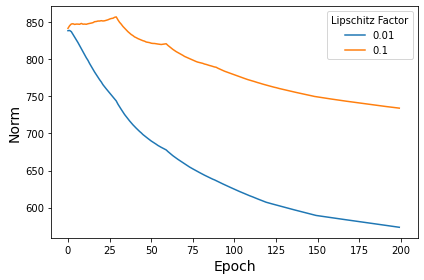

In [52]:
key_llf = lambda f: re.findall('llf=[^_]+', f)[0][4:]
key_lnf = lambda f: re.findall('lnf=[^_]+', f)[0][4:]
key_hf = lambda f: re.findall('hf=[^_]+', f)[0][3:]

# key_single = lambda f: re.findall('llf=[^_]+', f)[0].split('=')[1]
# key_double = lambda f: 'Factor=' + re.findall('llf=[^_]+', f)[0][4:] + '_' + 'NoiseFactor=' + re.findall('lnf=[^_]+', f)[0][4:]
# key_lips_homo = lambda f: 'LipschitzFactor=' + key_llf(f) + '_HomomorphicFactor=' + key_hf(f)

for root, ylabel, out_png in zip([
    'csvs/full_cifar/lipschitz/train_acc',
    'csvs/full_cifar/lipschitz/test_acc',
    'csvs/full_cifar/lipschitz/norm',
], [
    'Train Accuracy',
    'Test Accuracy',
    'Norm',
], [
    'plots/full_lips/model_ce_train_acc.png',
    'plots/full_lips/model_ce_test_acc.png',
    'plots/full_lips/model_ce_norm.png',
]):
    do_complete(
        root=root,
        key=key_llf,
        legend_title='Lipschitz Factor',
        ylabel=ylabel,
        out_png=out_png,
    )

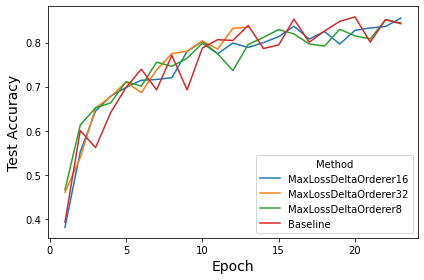

In [36]:
# Cristi stuff

def key(f):
    if 'Baseline' in f:
        return 'Baseline'
    if 'MultiAttemptOrderer' in f:
        return re.findall('MultiAttemptOrderer[^_]+', f)[0]
    if 'MaxLossDeltaOrderer' in f:
        return re.findall('MaxLossDeltaOrderer[^_]+', f)[0]
    assert False

baselines = {
    'Train': r'C:\Facultate\Tensor-Reloaded\Convergence\csvs\cristi\PreResNet(56)_Baseline_0-tag-Train_Accuracy.csv',
    'Test': r'C:\Facultate\Tensor-Reloaded\Convergence\csvs\cristi\PreResNet(56)_Baseline_0-tag-Test_Accuracy.csv',
}

# for r_orig in ['MaxLossDeltaOrdererAbsolute', 'MultiAttemptLossOrderer']:
for r_orig in ['MaxLossDeltaOrdererAbsolute']:
    # for r_orig in ['MultiAttemptLossOrderer']:
    r = os.path.join(r'C:\Facultate\Tensor-Reloaded\Convergence\csvs\cristi', r_orig)
    if not os.path.isdir(r):
        continue
    for t in ['Train', 'Test']:
        out_png = f'plots/cristi/{r_orig}_{t}.png'
        do_complete(
            root=os.path.join(r, t),
            key=key,
            legend_title='Method',
            ylabel=f'{t} Accuracy',
            out_png=out_png,
            extra_csv=baselines[t],
        )

In [14]:
def get_best_test_acc_path(root):
    if os.path.exists(os.path.join(root, 'test_acc')):
        root = os.path.join(root, 'test_acc')
    elif os.path.exists(os.path.join(root, 'test_acc_subset')):
        root = os.path.join(root, 'test_acc_subset')
    else:
        raise ValueError()
        
    v = []
    for f in os.listdir(root):
        f = os.path.join(root, f)
        df = pd.read_csv(f)
        v.append((f, df['Value'].max()))
    
    m = max(v, key=lambda e: e[1])
#     print(root, m[1])
    return m

In [33]:
root = r"C:\Facultate\Tensor-Reloaded\Bias-Variance-Tradeoff-Regularization\csvs\lipschitz"

dfs = {
    'baseline': r"C:\Facultate\Tensor-Reloaded\Bias-Variance-Tradeoff-Regularization\csvs\baseline\baseline_test_acc_subset\run-06-18_17-52-33_baseline_subset=1000_runs_PreResNet(56, dataset='CIFAR-10')_Lipschitz-Baseline_Homomorphic-Baseline_mse_0-tag-Test_Accuracy.csv",
    'block': get_best_test_acc_path(root + "\\block")[0],
    'superblock': get_best_test_acc_path(root + "\\superblock")[0],
    'model_mse': get_best_test_acc_path(root + "\\model_mse")[0],
    'model_ce': get_best_test_acc_path(root + "\\model_ce")[0],
}

dfs = {k: pd.read_csv(v) for k, v in dfs.items()}
plot(dfs)
out_png = 'plots/lipschitz/subset_all_test_acc.png'

plt.legend(title='Level')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
assert not os.path.isfile(out_png)
plt.tight_layout()
plt.savefig(out_png)

SyntaxError: invalid syntax (<ipython-input-33-503913e53791>, line 4)

In [47]:
root = r"C:\Facultate\Tensor-Reloaded\Bias-Variance-Tradeoff-Regularization\csvs\lipschitz"
bests_lipschitz = {
    'baseline': 0.4356,
    'block': get_best_test_acc_path(root + "\\block"),
    'superblock': get_best_test_acc_path(root + "\\superblock"),
    'model_mse': get_best_test_acc_path(root + "\\model_mse"),
    'model_ce': get_best_test_acc_path(root + "\\model_ce"),
}
bests_lipschitz

{'baseline': 0.4356,
 'block': ("C:\\Facultate\\Tensor-Reloaded\\Bias-Variance-Tradeoff-Regularization\\csvs\\lipschitz\\block\\test_acc\\run-06-19_23-19-34_1_lips=True_llvl=block_llf=1.0_lnf=0.35_lnfg=1.0_subset=1000_runs_PreResNet(56, dataset='CIFAR-10')_Lipschitz-Block_Hom.csv",
  0.4341999888420105),
 'superblock': ("C:\\Facultate\\Tensor-Reloaded\\Bias-Variance-Tradeoff-Regularization\\csvs\\lipschitz\\superblock\\test_acc\\run-06-20_02-14-56_0_lips=True_llvl=superblock_llf=0.01_lnf=0.35_lnfg=1.0_subset=1000_runs_PreResNet(56, dataset='CIFAR-10')_Lipschitz-SuperB.csv",
  0.4413999915122986),
 'model_mse': ("C:\\Facultate\\Tensor-Reloaded\\Bias-Variance-Tradeoff-Regularization\\csvs\\lipschitz\\model_mse\\test_acc\\run-06-20_02-14-56_5_lips=True_llvl=model_llf=0.1_lnf=0.35_lnfg=1.0_subset=1000_runs_PreResNet(56, dataset='CIFAR-10')_Lipschitz-Model_Hom.csv",
  0.4289999902248383),
 'model_ce': ("C:\\Facultate\\Tensor-Reloaded\\Bias-Variance-Tradeoff-Regularization\\csvs\\lipschitz\\

In [46]:
root = r"C:\Facultate\Tensor-Reloaded\Bias-Variance-Tradeoff-Regularization\csvs\homo"
bests_homo = {
    'baseline': 0.4356,
    'block': get_best_test_acc_path(root + "\\block"),
    'superblock': get_best_test_acc_path(root + "\\superblock"),
    'model_mse': get_best_test_acc_path(root + "\\model_mse"),
    'model_ce': get_best_test_acc_path(root + "\\model_ce"),
}
bests_homo

{'baseline': 0.4356,
 'block': ("C:\\Facultate\\Tensor-Reloaded\\Bias-Variance-Tradeoff-Regularization\\csvs\\homo\\block\\test_acc_subset\\run-06-18_18-17-59_0_homo=True_hf=100_hlvl=block_subset=1000_runs_PreResNet(56, dataset='CIFAR-10')_Lipschitz-Baseline_Homomorphic-Block-Cons.csv",
  0.3953999876976013),
 'superblock': ("C:\\Facultate\\Tensor-Reloaded\\Bias-Variance-Tradeoff-Regularization\\csvs\\homo\\superblock\\test_acc_subset\\run-06-18_18-34-51_1_homo=True_hf=20.0_hlvl=superblock_subset=1000_runs_PreResNet(56, dataset='CIFAR-10')_Lipschitz-Baseline_Homomorphic.csv",
  0.4181999862194061),
 'model_mse': ("C:\\Facultate\\Tensor-Reloaded\\Bias-Variance-Tradeoff-Regularization\\csvs\\homo\\model_mse\\test_acc_subset\\run-06-18_19-30-46_0_homo=True_hf=4.0_hlvl=model_subset=1000_runs_PreResNet(56, dataset='CIFAR-10')_Lipschitz-Baseline_Homomorphic-.csv",
  0.4955999851226807),
 'model_ce': ("C:\\Facultate\\Tensor-Reloaded\\Bias-Variance-Tradeoff-Regularization\\csvs\\homo\\model_ce